In [127]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import json
import pandas as pd
import sklearn
from tqdm import tqdm
import glob
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import numpy as np
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [2]:
# obtained from first month feature file
feature_columns = ['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID',
       'Date/Time (LST)', 'Year', 'Month', 'Day', 'Time (LST)', 'Temp (°C)',
       'Temp Flag', 'Dew Point Temp (°C)', 'Dew Point Temp Flag',
       'Rel Hum (%)', 'Rel Hum Flag', 'Precip. Amount (mm)',
       'Precip. Amount Flag', 'Wind Dir (10s deg)', 'Wind Dir Flag',
       'Wind Spd (km/h)', 'Wind Spd Flag', 'Visibility (km)',
       'Visibility Flag', 'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx',
       'Hmdx Flag', 'Wind Chill', 'Wind Chill Flag', 'Weather']

# Feature Preparation

In [3]:
monthly_data_files = glob.glob("../Data/2023-Ottawa-Weather/*.csv")

all_feature_dfs = []
for file in monthly_data_files:
    df = pd.read_csv(file)
    all_feature_dfs.append(df[feature_columns])

all_features = pd.concat(all_feature_dfs, axis=0, ignore_index = True)

In [4]:
all_features

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time (LST),Year,Month,Day,Time (LST),Temp (°C),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,-75.67,45.32,OTTAWA INTL A,6106001,2023-01-01 00:00,2023,1,1,00:00,3.0,...,NaN,0.4,NaN,99.11,NaN,NaN,NaN,NaN,NaN,Fog
1,-75.67,45.32,OTTAWA INTL A,6106001,2023-01-01 01:00,2023,1,1,01:00,3.0,...,NaN,0.4,NaN,99.16,NaN,NaN,NaN,NaN,NaN,Fog
2,-75.67,45.32,OTTAWA INTL A,6106001,2023-01-01 02:00,2023,1,1,02:00,3.0,...,NaN,6.4,NaN,99.22,NaN,NaN,NaN,NaN,NaN,Fog
3,-75.67,45.32,OTTAWA INTL A,6106001,2023-01-01 03:00,2023,1,1,03:00,2.6,...,NaN,8.1,NaN,99.27,NaN,NaN,NaN,NaN,NaN,Fog
4,-75.67,45.32,OTTAWA INTL A,6106001,2023-01-01 04:00,2023,1,1,04:00,2.4,...,NaN,11.3,NaN,99.33,NaN,NaN,NaN,NaN,NaN,Cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,-75.67,45.32,OTTAWA INTL A,6106001,2023-12-31 19:00,2023,12,31,19:00,-6.7,...,NaN,24.1,NaN,100.37,NaN,NaN,NaN,-9.0,NaN,Mostly Cloudy
8756,-75.67,45.32,OTTAWA INTL A,6106001,2023-12-31 20:00,2023,12,31,20:00,-6.6,...,NaN,24.1,NaN,100.35,NaN,NaN,NaN,-10.0,NaN,NaN
8757,-75.67,45.32,OTTAWA INTL A,6106001,2023-12-31 21:00,2023,12,31,21:00,-8.0,...,NaN,24.1,NaN,100.37,NaN,NaN,NaN,-12.0,NaN,NaN
8758,-75.67,45.32,OTTAWA INTL A,6106001,2023-12-31 22:00,2023,12,31,22:00,-7.5,...,NaN,24.1,NaN,100.38,NaN,NaN,NaN,-11.0,NaN,Mostly Cloudy


In [5]:
# do some innitial pre-processing for performing the join
all_features['Date/Time (LST)'] = pd.to_datetime(all_features['Date/Time (LST)'])
all_features = all_features.rename(columns={'Date/Time (LST)':'DateTime'})

# Target file

In [6]:
target_df = pd.read_csv("../Data/FSS Main 2023.csv")

In [7]:
target_df.columns

Index(['DateTime', 'FSS Main'], dtype='object')

In [8]:
target_df['DateTime'] = pd.to_datetime(target_df['DateTime'])

In [9]:
print(all_features['DateTime'].nunique())
print(target_df['DateTime'].nunique())

8760
8756


In [10]:
print(len(all_features))
print(len(target_df))

8760
8757


In [11]:
target_df_duplicated = target_df[target_df.duplicated(subset=['DateTime'], keep=False)]
print(target_df_duplicated)

                DateTime  FSS Main
1681 2023-03-12 03:00:00   420.605
1682 2023-03-12 03:00:00    35.535


In [12]:
target_df_nodup = target_df.drop_duplicates(subset=['DateTime'], keep='first')

In [13]:
print(target_df_nodup['DateTime'].nunique())
print(len(target_df_nodup['DateTime']))

8756
8756


In [14]:
# slide the datetime of meter reading to 1 hr before the recorded time to align with the datetime column of features
target_df_nodup.loc[:, 'DateTime'] = target_df_nodup['DateTime'] - timedelta(hours=1)

C:\Users\67532\AppData\Local\Temp\ipykernel_41612\3357958016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df_nodup.loc[:, 'DateTime'] = target_df_nodup['DateTime'] - timedelta(hours=1)
C:\Users\67532\AppData\Local\Temp\ipykernel_41612\3357958016.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  target_df_nodup.loc[:, 'DateTime'] = target_df_nodup['DateTime'] - timedelta(hours=1)


In [15]:
# we can see the shifted rows here
display(target_df.head(4))
display(target_df_nodup.head(4))

,DateTime,FSS Main
0,2023-01-01 01:00:00,350.991
1,2023-01-01 02:00:00,352.707
2,2023-01-01 03:00:00,349.177
3,2023-01-01 04:00:00,349.923


,DateTime,FSS Main
0,2023-01-01 00:00:00,350.991
1,2023-01-01 01:00:00,352.707
2,2023-01-01 02:00:00,349.177
3,2023-01-01 03:00:00,349.923


In [16]:
# rename FSS Main to Meter Reading (KWHr)
target_df_nodup = target_df_nodup.rename(columns = {'FSS Main':'Meter Reading (KWHr)'})

# Merge Dataframes based on Datetime

In [17]:
merged_df = pd.merge(target_df_nodup, all_features, on='DateTime', how='left')

In [18]:
merged_columns = " ; ".join(feature_columns).replace("Date/Time (LST)","DateTime").split(" ; ") + ["Meter Reading (KWHr)"]
# rearrange columns
merged_df = merged_df[merged_columns]

In [19]:
merged_df

,Longitude (x),Latitude (y),Station Name,Climate ID,DateTime,Year,Month,Day,Time (LST),Temp (°C),...,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Meter Reading (KWHr)
0,-75.67,45.32,OTTAWA INTL A,6106001,2023-01-01 00:00:00,2023,1,1,00:00,3.0,...,0.4,NaN,99.11,NaN,NaN,NaN,NaN,NaN,Fog,350.991
1,-75.67,45.32,OTTAWA INTL A,6106001,2023-01-01 01:00:00,2023,1,1,01:00,3.0,...,0.4,NaN,99.16,NaN,NaN,NaN,NaN,NaN,Fog,352.707
2,-75.67,45.32,OTTAWA INTL A,6106001,2023-01-01 02:00:00,2023,1,1,02:00,3.0,...,6.4,NaN,99.22,NaN,NaN,NaN,NaN,NaN,Fog,349.177
3,-75.67,45.32,OTTAWA INTL A,6106001,2023-01-01 03:00:00,2023,1,1,03:00,2.6,...,8.1,NaN,99.27,NaN,NaN,NaN,NaN,NaN,Fog,349.923
4,-75.67,45.32,OTTAWA INTL A,6106001,2023-01-01 04:00:00,2023,1,1,04:00,2.4,...,11.3,NaN,99.33,NaN,NaN,NaN,NaN,NaN,Cloudy,351.596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8751,-75.67,45.32,OTTAWA INTL A,6106001,2023-12-31 19:00:00,2023,12,31,19:00,-6.7,...,24.1,NaN,100.37,NaN,NaN,NaN,-9.0,NaN,Mostly Cloudy,422.618
8752,-75.67,45.32,OTTAWA INTL A,6106001,2023-12-31 20:00:00,2023,12,31,20:00,-6.6,...,24.1,NaN,100.35,NaN,NaN,NaN,-10.0,NaN,NaN,421.912
8753,-75.67,45.32,OTTAWA INTL A,6106001,2023-12-31 21:00:00,2023,12,31,21:00,-8.0,...,24.1,NaN,100.37,NaN,NaN,NaN,-12.0,NaN,NaN,353.075
8754,-75.67,45.32,OTTAWA INTL A,6106001,2023-12-31 22:00:00,2023,12,31,22:00,-7.5,...,24.1,NaN,100.38,NaN,NaN,NaN,-11.0,NaN,Mostly Cloudy,427.166


In [20]:
merged_df.columns

Index(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID',
       'DateTime', 'Year', 'Month', 'Day', 'Time (LST)', 'Temp (°C)',
       'Temp Flag', 'Dew Point Temp (°C)', 'Dew Point Temp Flag',
       'Rel Hum (%)', 'Rel Hum Flag', 'Precip. Amount (mm)',
       'Precip. Amount Flag', 'Wind Dir (10s deg)', 'Wind Dir Flag',
       'Wind Spd (km/h)', 'Wind Spd Flag', 'Visibility (km)',
       'Visibility Flag', 'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx',
       'Hmdx Flag', 'Wind Chill', 'Wind Chill Flag', 'Weather',
       'Meter Reading (KWHr)'],
      dtype='object')

In [21]:
merged_df.to_csv('../Data/merged_data_newData.csv', index=False)

# EDA

Text(0.5, 1.0, 'Barplots for Month and Temp')

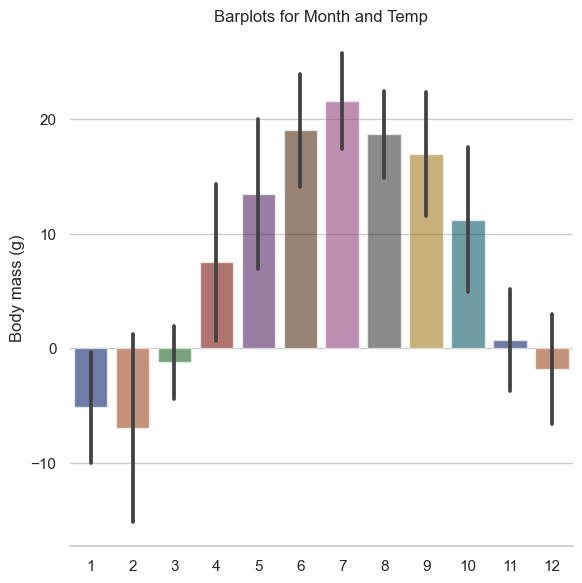

In [22]:
sns.set_theme(style="whitegrid")

EDA_data=pd.read_csv("../Data/merged_data_newData.csv")
# Draw a nested barplot by month and Temp
g = sns.catplot(
    data=EDA_data, kind="bar",
    x="Month", y="Temp (°C)",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
plt.title("Barplots for Month and Temp")

Text(0.5, 1.0, 'Barplots for Month and Dew Point Temp')

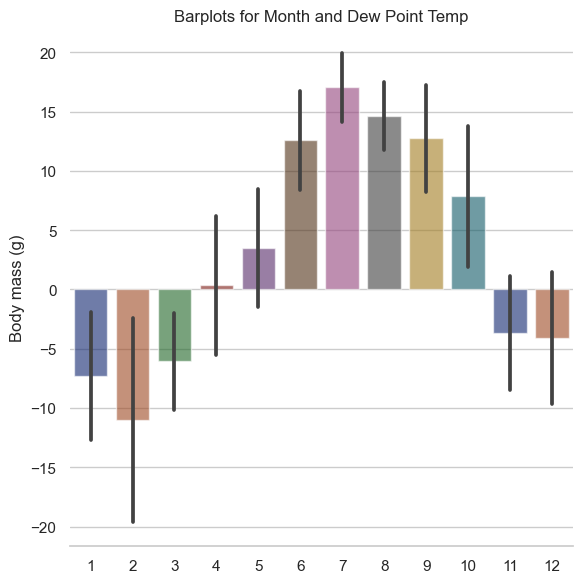

In [23]:
# Draw a nested barplot by month and Dew Point Temp
g = sns.catplot(
    data=EDA_data, kind="bar",
    x="Month", y="Dew Point Temp (°C)",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
plt.title("Barplots for Month and Dew Point Temp")

Text(0.5, 1.0, 'Boxplots for Visibility and Meter Reading')

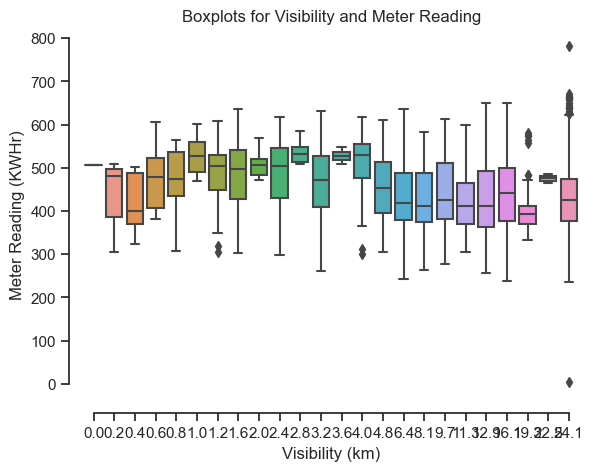

In [24]:
sns.set_theme(style="ticks", palette="pastel")

boxplot_data=EDA_data
boxplot_data=boxplot_data.sort_values(by='Visibility (km)')
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="Visibility (km)", y="Meter Reading (KWHr)",
            data=boxplot_data)

sns.despine(offset=10, trim=True)
plt.title("Boxplots for Visibility and Meter Reading")

D:\Anaconda\file\lib\site-packages\seaborn\axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
D:\Anaconda\file\lib\site-packages\seaborn\axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)


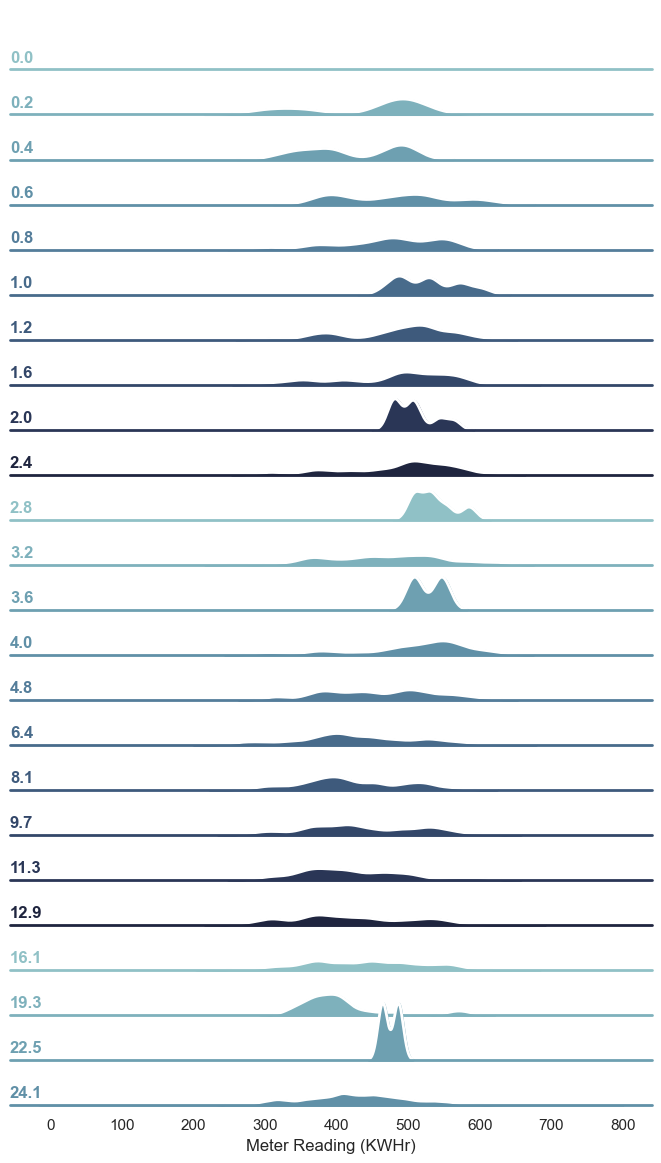

In [25]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(EDA_data, row="Visibility (km)", hue="Visibility (km)", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Meter Reading (KWHr)",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Meter Reading (KWHr)", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Meter Reading (KWHr)")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)



D:\Anaconda\file\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
D:\Anaconda\file\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
D:\Anaconda\file\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
D:\Anaconda\file\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


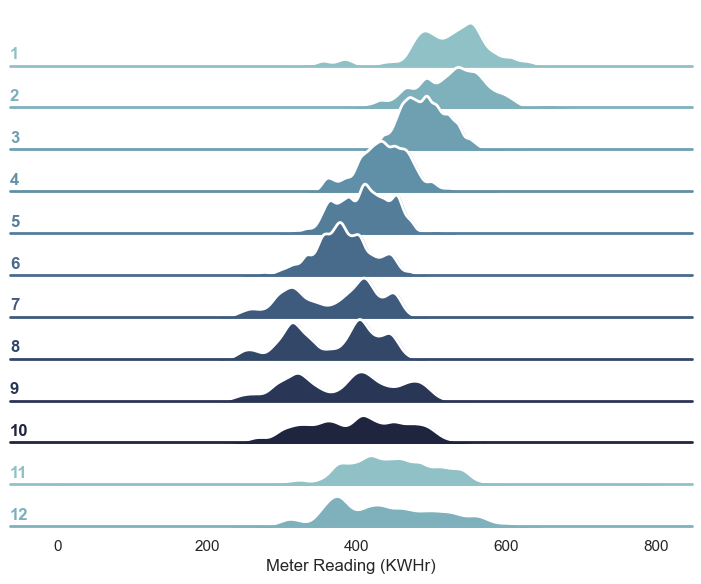

In [26]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(EDA_data, row="Month", hue="Month", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Meter Reading (KWHr)",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Meter Reading (KWHr)", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Meter Reading (KWHr)")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)



Text(0, 0.5, 'Meter Reading(KWHr)')

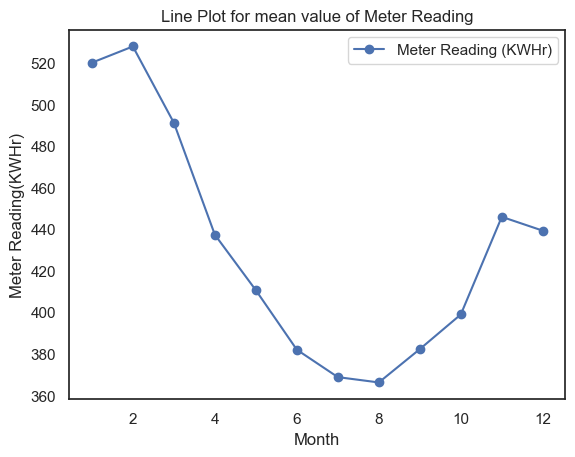

In [46]:
Mean_Meter_Reading=[]

for i in range(1,13):
    mean=EDA_data[EDA_data['Month']==i]
    Mean_Meter_Reading.append(np.mean(mean['Meter Reading (KWHr)']))

month_list=list(range(1,13))

plt.plot(month_list, Mean_Meter_Reading, marker='o', linestyle='-', color='b')

plt.legend(labels=['Meter Reading (KWHr)'],facecolor='white')

plt.title('Line Plot for mean value of Meter Reading')
plt.xlabel('Month')
plt.ylabel('Meter Reading(KWHr)')

Text(0, 0.5, 'Visibility (km)')

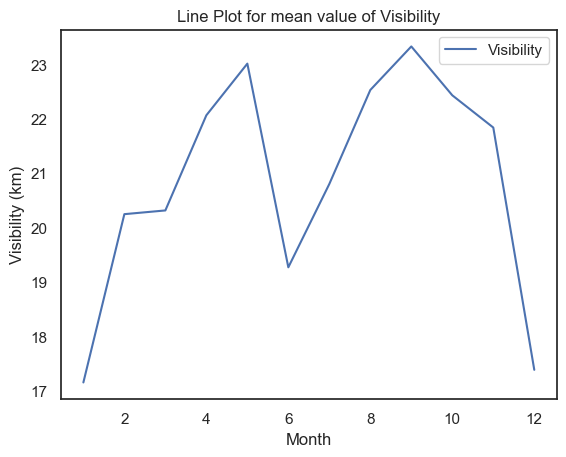

In [47]:
Mean_Visibility=[]
for i in range(1,13):
    mean=EDA_data[EDA_data['Month']==i]
    Mean_Visibility.append(np.mean(mean['Visibility (km)']))

month_list=list(range(1,13))

plt.plot(month_list, Mean_Visibility, label='Line 3')

plt.legend(labels=['Visibility'],facecolor='white')

plt.title('Line Plot for mean value of Visibility')
plt.xlabel('Month')
plt.ylabel('Visibility (km)')

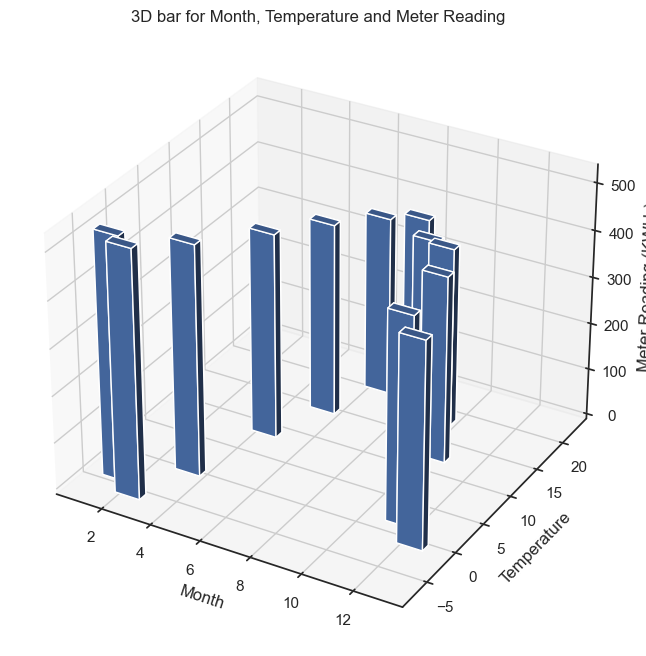

In [56]:
from mpl_toolkits.mplot3d import Axes3D

month_list=list(range(1,13))
Mean_Meter_Reading=[]
Mean_Temp=[]
for i in range(1,13):
    mean=EDA_data[EDA_data['Month']==i]
    Mean_Temp.append(np.mean(mean['Temp (°C)']))
    Mean_Meter_Reading.append(np.mean(mean['Meter Reading (KWHr)']))
y = Mean_Temp
z = np.zeros_like(month_list)  
dx = dy = np.ones_like(month_list) 
dz = Mean_Meter_Reading 


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.bar3d(month_list, y, z, dx, dy, dz)

plt.title('3D bar for Month, Temperature and Meter Reading')
ax.set_xlabel('Month')
ax.set_ylabel('Temperature')
ax.set_zlabel('Meter Reading (KWHr)')


plt.show()

# Perform Feature Processing

In [57]:
data_df = pd.read_csv("../Data/merged_data_newData.csv")

In [58]:
data_df.head(5)

,Longitude (x),Latitude (y),Station Name,Climate ID,DateTime,Year,Month,Day,Time (LST),Temp (°C),...,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Meter Reading (KWHr)
0,-75.67,45.32,OTTAWA INTL A,6106001,2023-01-01 00:00:00,2023,1,1,00:00,3.0,...,0.4,NaN,99.11,NaN,NaN,NaN,NaN,NaN,Fog,350.991
1,-75.67,45.32,OTTAWA INTL A,6106001,2023-01-01 01:00:00,2023,1,1,01:00,3.0,...,0.4,NaN,99.16,NaN,NaN,NaN,NaN,NaN,Fog,352.707
2,-75.67,45.32,OTTAWA INTL A,6106001,2023-01-01 02:00:00,2023,1,1,02:00,3.0,...,6.4,NaN,99.22,NaN,NaN,NaN,NaN,NaN,Fog,349.177
3,-75.67,45.32,OTTAWA INTL A,6106001,2023-01-01 03:00:00,2023,1,1,03:00,2.6,...,8.1,NaN,99.27,NaN,NaN,NaN,NaN,NaN,Fog,349.923
4,-75.67,45.32,OTTAWA INTL A,6106001,2023-01-01 04:00:00,2023,1,1,04:00,2.4,...,11.3,NaN,99.33,NaN,NaN,NaN,NaN,NaN,Cloudy,351.596


In [59]:
# find number of missing values per column
missing_stats = data_df.isnull().sum()
missing_stats

Longitude (x)              0
Latitude (y)               0
Station Name               0
Climate ID                 0
DateTime                   0
Year                       0
Month                      0
Day                        0
Time (LST)                 0
Temp (°C)                  2
Temp Flag               8756
Dew Point Temp (°C)        2
Dew Point Temp Flag     8756
Rel Hum (%)                2
Rel Hum Flag            8756
Precip. Amount (mm)     8756
Precip. Amount Flag     8756
Wind Dir (10s deg)         6
Wind Dir Flag           8756
Wind Spd (km/h)            2
Wind Spd Flag           8756
Visibility (km)            2
Visibility Flag         8756
Stn Press (kPa)            2
Stn Press Flag          8756
Hmdx                    7600
Hmdx Flag               8756
Wind Chill              6236
Wind Chill Flag         8756
Weather                 4657
Meter Reading (KWHr)       0
dtype: int64

In [60]:
# drop columns which are completely empty
drop_cols = missing_stats[(missing_stats==len(data_df))].index.to_list()
drop_cols

# additional drop columns with same value for all the rows
add_drop = [col for col in data_df.columns if data_df[col].nunique()==1]
drop_cols += add_drop

# drop other columns based on domain knowledge (non useful details)
domain_drop = ['DateTime']
drop_cols += domain_drop

print("Columns to drop: ", drop_cols)

Columns to drop:  ['Temp Flag', 'Dew Point Temp Flag', 'Rel Hum Flag', 'Precip. Amount (mm)', 'Precip. Amount Flag', 'Wind Dir Flag', 'Wind Spd Flag', 'Visibility Flag', 'Stn Press Flag', 'Hmdx Flag', 'Wind Chill Flag', 'Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year', 'DateTime']


In [61]:
data_df.drop(columns=drop_cols, inplace = True)

In [62]:
data_df

,Month,Day,Time (LST),Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather,Meter Reading (KWHr)
0,1,1,00:00,3.0,3.0,100.0,28.0,11.0,0.4,99.11,NaN,NaN,Fog,350.991
1,1,1,01:00,3.0,3.0,100.0,26.0,10.0,0.4,99.16,NaN,NaN,Fog,352.707
2,1,1,02:00,3.0,3.0,100.0,30.0,21.0,6.4,99.22,NaN,NaN,Fog,349.177
3,1,1,03:00,2.6,2.6,100.0,28.0,24.0,8.1,99.27,NaN,NaN,Fog,349.923
4,1,1,04:00,2.4,2.4,100.0,28.0,23.0,11.3,99.33,NaN,NaN,Cloudy,351.596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8751,12,31,19:00,-6.7,-10.3,76.0,26.0,5.0,24.1,100.37,NaN,-9.0,Mostly Cloudy,422.618
8752,12,31,20:00,-6.6,-10.2,76.0,30.0,7.0,24.1,100.35,NaN,-10.0,NaN,421.912
8753,12,31,21:00,-8.0,-10.9,80.0,28.0,8.0,24.1,100.37,NaN,-12.0,NaN,353.075
8754,12,31,22:00,-7.5,-10.1,82.0,29.0,7.0,24.1,100.38,NaN,-11.0,Mostly Cloudy,427.166


In [63]:
# now replace time value to categorical values for post 1-hot encoding
# Convert Time or hour of the day to categorical columns
data_df['Time (LST)'] = pd.to_datetime(data_df['Time (LST)'])
# create labels for hours
labels_hrs = [f'hour_{i}' for i in range(0,24)]
data_df['Time (LST)'] = pd.cut(data_df['Time (LST)'].dt.hour, bins=range(0,25), right=False, labels=labels_hrs)

In [64]:
data_df.head(5)

,Month,Day,Time (LST),Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather,Meter Reading (KWHr)
0,1,1,hour_0,3.0,3.0,100.0,28.0,11.0,0.4,99.11,NaN,NaN,Fog,350.991
1,1,1,hour_1,3.0,3.0,100.0,26.0,10.0,0.4,99.16,NaN,NaN,Fog,352.707
2,1,1,hour_2,3.0,3.0,100.0,30.0,21.0,6.4,99.22,NaN,NaN,Fog,349.177
3,1,1,hour_3,2.6,2.6,100.0,28.0,24.0,8.1,99.27,NaN,NaN,Fog,349.923
4,1,1,hour_4,2.4,2.4,100.0,28.0,23.0,11.3,99.33,NaN,NaN,Cloudy,351.596


In [65]:
missing_stats_post = data_df.isnull().sum()
missing_stats_post

Month                      0
Day                        0
Time (LST)                 0
Temp (°C)                  2
Dew Point Temp (°C)        2
Rel Hum (%)                2
Wind Dir (10s deg)         6
Wind Spd (km/h)            2
Visibility (km)            2
Stn Press (kPa)            2
Hmdx                    7600
Wind Chill              6236
Weather                 4657
Meter Reading (KWHr)       0
dtype: int64

Mean Value:  29.60553633217993 Median Value:  29.0 Mode Value:  0    28.0
Name: Hmdx, dtype: float64


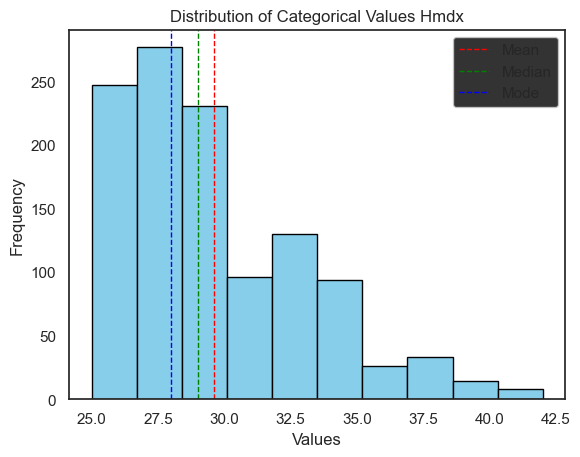

Mean Value:  -10.91904761904762 Median Value:  -9.0 Mode Value:  0   -6.0
Name: Wind Chill, dtype: float64


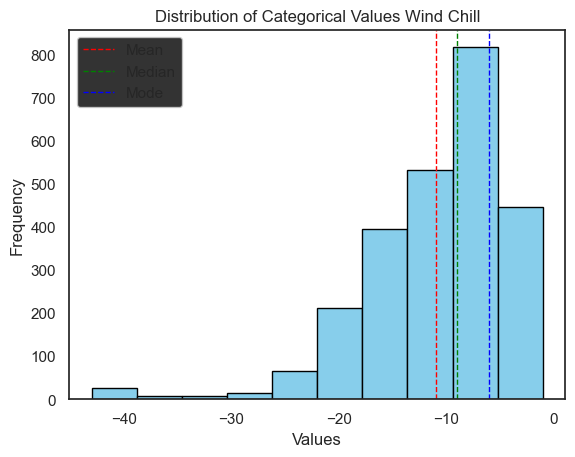

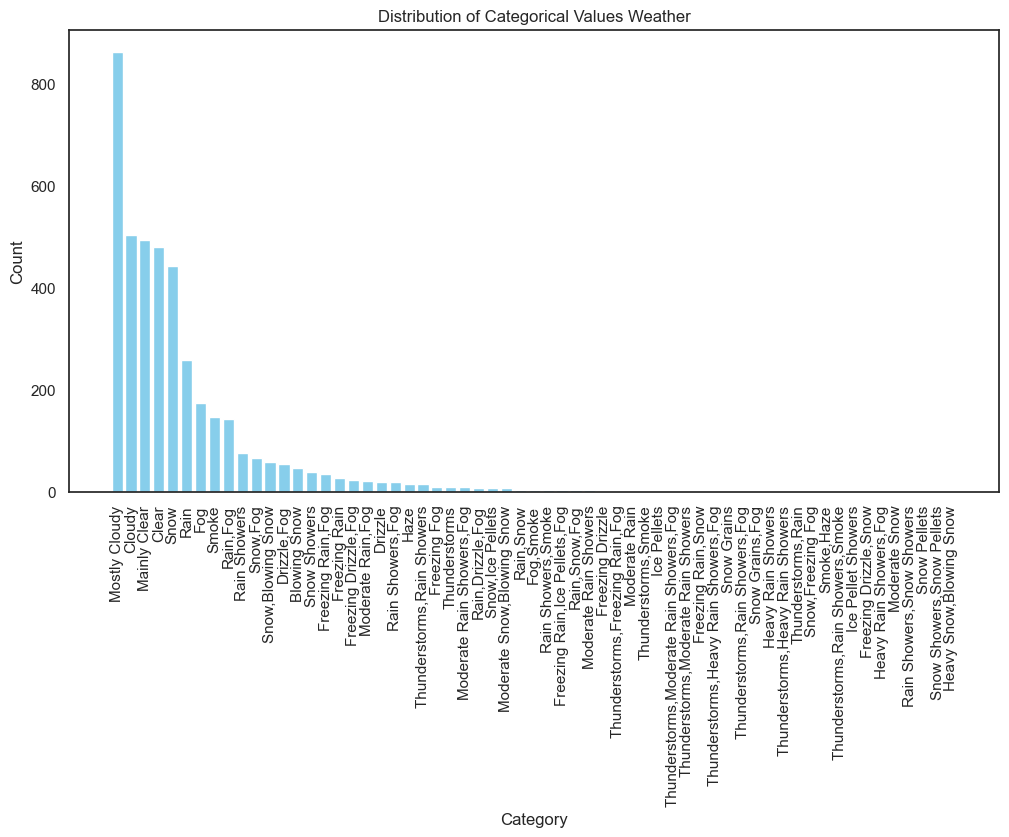

In [66]:
def plot_feature_distribution(data_df, column):
    # we observe that Hmdx, Wind Chill and Weather have the most number of missing values
    chop = data_df[column].dropna()
    
    if data_df[column].dtype in ["category","object"]:
        # for categorical columns
        category_counts = chop.value_counts()
        # print(category_counts.index.tolist())
        plt.figure(figsize=(12, 6))
        plt.bar(category_counts.index, category_counts.values, color='skyblue', width = 0.8)
        plt.xticks(rotation=90)
        plt.xlabel('Category')
        plt.ylabel('Count')
        plt.title(f'Distribution of Categorical Values {column}')
        
    elif data_df[column].dtype in ["float64","int64"]:
        # for other continous variable columns
        plt.hist(chop, bins=10, color='skyblue', edgecolor='black')
        # Calculate mean value
        print("Mean Value: ", chop.mean(), "Median Value: ", chop.median(), "Mode Value: ", chop.mode())
        # Add a vertical line at the mean value
        plt.axvline(chop.mean(), color='red', linestyle='dashed', linewidth=1)
        plt.axvline(chop.median(), color='green', linestyle='dashed', linewidth=1)
        plt.axvline(chop.mode()[0], color='blue', linestyle='dashed', linewidth=1)

        plt.legend(['Mean', 'Median', 'Mode'])

        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Categorical Values {column}')
        
    plt.show()
    
# plot distribbutions and measure of central tendencies
plot_feature_distribution(data_df, "Hmdx")
plot_feature_distribution(data_df, "Wind Chill")
plot_feature_distribution(data_df, "Weather")

In [67]:
# fill the missing values
data_df = data_df.fillna(data_df.mode().iloc[0])

In [68]:
data_df.head(5)

,Month,Day,Time (LST),Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather,Meter Reading (KWHr)
0,1,1,hour_0,3.0,3.0,100.0,28.0,11.0,0.4,99.11,28.0,-6.0,Fog,350.991
1,1,1,hour_1,3.0,3.0,100.0,26.0,10.0,0.4,99.16,28.0,-6.0,Fog,352.707
2,1,1,hour_2,3.0,3.0,100.0,30.0,21.0,6.4,99.22,28.0,-6.0,Fog,349.177
3,1,1,hour_3,2.6,2.6,100.0,28.0,24.0,8.1,99.27,28.0,-6.0,Fog,349.923
4,1,1,hour_4,2.4,2.4,100.0,28.0,23.0,11.3,99.33,28.0,-6.0,Cloudy,351.596


In [69]:
# split the Weather column (as its based on concatenation of multiple weather attributes)
weather_values = set(data_df['Weather'].tolist())

weather_values = [x.split(",") for x in weather_values]
weather_values_mod = []
for weath_sub in weather_values:
    weather_values_mod.extend(weath_sub)
weather_values = set(weather_values_mod)
print("Unique weather categories: ", weather_values, "Num unique categories: ", len(weather_values))

Unique weather categories:  {'Snow Grains', 'Ice Pellet Showers', 'Snow Pellets', 'Clear', 'Rain', 'Blowing Snow', 'Rain Showers', 'Mostly Cloudy', 'Freezing Drizzle', 'Mainly Clear', 'Cloudy', 'Heavy Rain Showers', 'Freezing Rain', 'Heavy Snow', 'Thunderstorms', 'Moderate Rain Showers', 'Moderate Snow', 'Drizzle', 'Snow Showers', 'Snow', 'Fog', 'Ice Pellets', 'Haze', 'Freezing Fog', 'Moderate Rain', 'Smoke'} Num unique categories:  26


In [70]:
for un_weath_category in weather_values:
    # create a category name same as the unique category
    data_df[un_weath_category]=data_df['Weather'].apply(lambda col_val: int(un_weath_category in col_val.split(",")))

In [71]:
pd.set_option('display.max_columns', None)
data_df.head(5)

,Month,Day,Time (LST),Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather,Meter Reading (KWHr),Snow Grains,Ice Pellet Showers,Snow Pellets,Clear,Rain,Blowing Snow,Rain Showers,Mostly Cloudy,Freezing Drizzle,Mainly Clear,Cloudy,Heavy Rain Showers,Freezing Rain,Heavy Snow,Thunderstorms,Moderate Rain Showers,Moderate Snow,Drizzle,Snow Showers,Snow,Fog,Ice Pellets,Haze,Freezing Fog,Moderate Rain,Smoke
0,1,1,hour_0,3.0,3.0,100.0,28.0,11.0,0.4,99.11,28.0,-6.0,Fog,350.991,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,1,hour_1,3.0,3.0,100.0,26.0,10.0,0.4,99.16,28.0,-6.0,Fog,352.707,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,1,hour_2,3.0,3.0,100.0,30.0,21.0,6.4,99.22,28.0,-6.0,Fog,349.177,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,1,hour_3,2.6,2.6,100.0,28.0,24.0,8.1,99.27,28.0,-6.0,Fog,349.923,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,1,hour_4,2.4,2.4,100.0,28.0,23.0,11.3,99.33,28.0,-6.0,Cloudy,351.596,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [73]:
# Save intermediate dataframe for EDA
data_df.to_csv("../Data/eda_newData.csv", index = False)

In [74]:
# now we can convert categorical value to their one-hot encoding
# first we get rid of weather column as its converted
data_df.drop(columns=['Weather'], inplace=True)

In [75]:
# we see that only one column is categorical (the hour data that we converted earlier)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8756 entries, 0 to 8755
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Month                  8756 non-null   int64   
 1   Day                    8756 non-null   int64   
 2   Time (LST)             8756 non-null   category
 3   Temp (°C)              8756 non-null   float64 
 4   Dew Point Temp (°C)    8756 non-null   float64 
 5   Rel Hum (%)            8756 non-null   float64 
 6   Wind Dir (10s deg)     8756 non-null   float64 
 7   Wind Spd (km/h)        8756 non-null   float64 
 8   Visibility (km)        8756 non-null   float64 
 9   Stn Press (kPa)        8756 non-null   float64 
 10  Hmdx                   8756 non-null   float64 
 11  Wind Chill             8756 non-null   float64 
 12  Meter Reading (KWHr)   8756 non-null   float64 
 13  Snow Grains            8756 non-null   int64   
 14  Ice Pellet Showers     8756 non-null   i

In [76]:
data_df_exp = pd.get_dummies(data_df, dtype='int64')

In [77]:
pd.set_option('display.max_columns', None)
data_df_exp.head(5)

,Month,Day,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Meter Reading (KWHr),Snow Grains,Ice Pellet Showers,Snow Pellets,Clear,Rain,Blowing Snow,Rain Showers,Mostly Cloudy,Freezing Drizzle,Mainly Clear,Cloudy,Heavy Rain Showers,Freezing Rain,Heavy Snow,Thunderstorms,Moderate Rain Showers,Moderate Snow,Drizzle,Snow Showers,Snow,Fog,Ice Pellets,Haze,Freezing Fog,Moderate Rain,Smoke,Time (LST)_hour_0,Time (LST)_hour_1,Time (LST)_hour_2,Time (LST)_hour_3,Time (LST)_hour_4,Time (LST)_hour_5,Time (LST)_hour_6,Time (LST)_hour_7,Time (LST)_hour_8,Time (LST)_hour_9,Time (LST)_hour_10,Time (LST)_hour_11,Time (LST)_hour_12,Time (LST)_hour_13,Time (LST)_hour_14,Time (LST)_hour_15,Time (LST)_hour_16,Time (LST)_hour_17,Time (LST)_hour_18,Time (LST)_hour_19,Time (LST)_hour_20,Time (LST)_hour_21,Time (LST)_hour_22,Time (LST)_hour_23
0,1,1,3.0,3.0,100.0,28.0,11.0,0.4,99.11,28.0,-6.0,350.991,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,3.0,3.0,100.0,26.0,10.0,0.4,99.16,28.0,-6.0,352.707,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,3.0,3.0,100.0,30.0,21.0,6.4,99.22,28.0,-6.0,349.177,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,2.6,2.6,100.0,28.0,24.0,8.1,99.27,28.0,-6.0,349.923,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,2.4,2.4,100.0,28.0,23.0,11.3,99.33,28.0,-6.0,351.596,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [78]:
# we only have integer or float columns currently
data_df_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8756 entries, 0 to 8755
Data columns (total 62 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Month                  8756 non-null   int64  
 1   Day                    8756 non-null   int64  
 2   Temp (°C)              8756 non-null   float64
 3   Dew Point Temp (°C)    8756 non-null   float64
 4   Rel Hum (%)            8756 non-null   float64
 5   Wind Dir (10s deg)     8756 non-null   float64
 6   Wind Spd (km/h)        8756 non-null   float64
 7   Visibility (km)        8756 non-null   float64
 8   Stn Press (kPa)        8756 non-null   float64
 9   Hmdx                   8756 non-null   float64
 10  Wind Chill             8756 non-null   float64
 11  Meter Reading (KWHr)   8756 non-null   float64
 12  Snow Grains            8756 non-null   int64  
 13  Ice Pellet Showers     8756 non-null   int64  
 14  Snow Pellets           8756 non-null   int64  
 15  Clea

In [79]:
scaler = MinMaxScaler()
# now we can perform min-max normalization on all columns before feature preparation
data_df = data_df_exp.drop(columns=['Meter Reading (KWHr)'])
data_df_norm = pd.DataFrame(scaler.fit_transform(data_df), columns=data_df.columns)
data_df_norm = pd.concat([data_df_norm, data_df_exp['Meter Reading (KWHr)']], axis=1)

In [80]:
data_df_norm

,Month,Day,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Snow Grains,Ice Pellet Showers,Snow Pellets,Clear,Rain,Blowing Snow,Rain Showers,Mostly Cloudy,Freezing Drizzle,Mainly Clear,Cloudy,Heavy Rain Showers,Freezing Rain,Heavy Snow,Thunderstorms,Moderate Rain Showers,Moderate Snow,Drizzle,Snow Showers,Snow,Fog,Ice Pellets,Haze,Freezing Fog,Moderate Rain,Smoke,Time (LST)_hour_0,Time (LST)_hour_1,Time (LST)_hour_2,Time (LST)_hour_3,Time (LST)_hour_4,Time (LST)_hour_5,Time (LST)_hour_6,Time (LST)_hour_7,Time (LST)_hour_8,Time (LST)_hour_9,Time (LST)_hour_10,Time (LST)_hour_11,Time (LST)_hour_12,Time (LST)_hour_13,Time (LST)_hour_14,Time (LST)_hour_15,Time (LST)_hour_16,Time (LST)_hour_17,Time (LST)_hour_18,Time (LST)_hour_19,Time (LST)_hour_20,Time (LST)_hour_21,Time (LST)_hour_22,Time (LST)_hour_23,Meter Reading (KWHr)
0,0.0,0.0,0.530920,0.652755,1.000000,0.777778,0.211538,0.016598,0.408935,0.176471,0.880952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350.991
1,0.0,0.0,0.530920,0.652755,1.000000,0.722222,0.192308,0.016598,0.417526,0.176471,0.880952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,352.707
2,0.0,0.0,0.530920,0.652755,1.000000,0.833333,0.403846,0.265560,0.427835,0.176471,0.880952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,349.177
3,0.0,0.0,0.524887,0.646077,1.000000,0.777778,0.461538,0.336100,0.436426,0.176471,0.880952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,349.923
4,0.0,0.0,0.521870,0.642738,1.000000,0.777778,0.442308,0.468880,0.446735,0.176471,0.880952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,351.596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8751,1.0,1.0,0.384615,0.430718,0.703704,0.722222,0.096154,1.000000,0.625430,0.176471,0.809524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,422.618
8752,1.0,1.0,0.386124,0.432387,0.703704,0.833333,0.134615,1.000000,0.621993,0.176471,0.785714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,421.912
8753,1.0,1.0,0.365008,0.420701,0.753086,0.777778,0.153846,1.000000,0.625430,0.176471,0.738095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,353.075
8754,1.0,1.0,0.372549,0.434057,0.777778,0.805556,0.134615,1.000000,0.627148,0.176471,0.761905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,427.166


In [81]:
# see the converted data types
data_df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8756 entries, 0 to 8755
Data columns (total 62 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Month                  8756 non-null   float64
 1   Day                    8756 non-null   float64
 2   Temp (°C)              8756 non-null   float64
 3   Dew Point Temp (°C)    8756 non-null   float64
 4   Rel Hum (%)            8756 non-null   float64
 5   Wind Dir (10s deg)     8756 non-null   float64
 6   Wind Spd (km/h)        8756 non-null   float64
 7   Visibility (km)        8756 non-null   float64
 8   Stn Press (kPa)        8756 non-null   float64
 9   Hmdx                   8756 non-null   float64
 10  Wind Chill             8756 non-null   float64
 11  Snow Grains            8756 non-null   float64
 12  Ice Pellet Showers     8756 non-null   float64
 13  Snow Pellets           8756 non-null   float64
 14  Clear                  8756 non-null   float64
 15  Rain

In [83]:
data_df_norm.to_csv("../Data/preprocessed_newData.csv", index = False)

# Feature Selection for Regression using Statistical Analysis

In [86]:
df = pd.read_csv("../Data/preprocessed_newData.csv")

In [87]:
all_cols = df.columns

target_col = "Meter Reading (KWHr)"
feature_col = all_cols.drop(target_col).tolist()
target_col = [target_col]

In [88]:
# we use mutual info regression to determine feature importance (as F-statistic) can only capture linear dependencies
# between feature and the target variable
features_df = df[feature_col]
target_df = df[target_col]

mi_scores = mutual_info_regression(features_df, target_df)

# create a mapping from column name to value
feature_imp_map = {feature:mi_scores[i] for i, feature in enumerate(features_df.columns)}

D:\Anaconda\file\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [89]:
# sort the values
sorted_feature_imp = sorted(feature_imp_map.items(), key=lambda x: -x[1])

Text(0.5, 1.0, 'Mutual Information')

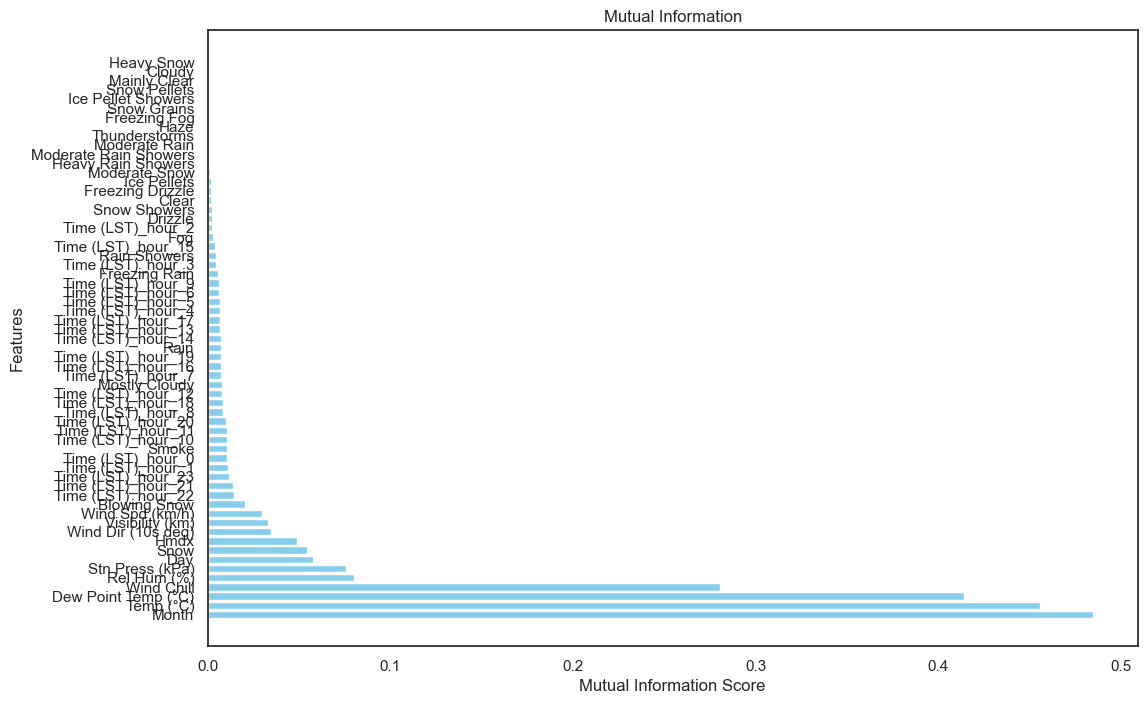

In [90]:
# Extracting labels and values
labels, values = zip(*sorted_feature_imp)

# Plotting the bar graph
plt.figure(figsize=(12, 8))
plt.barh(labels, values, color='skyblue')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Mutual Information')

## We can note the feature importances of the data from the above graph (its skewed to the right)
1.  The categorical features for hour and type of weather have very less importance according to mutual information with the target variable
2.  For the purpose of this experiment, we select the top-k features where k is determined based on the first index where feature impotance becomes 0 (features arranged in decreasing order of magnitude of the feature importance)

In [91]:
# find features with zero importance 
filtered_features = [entry[0] for entry in sorted_feature_imp if entry[1]!=0]
print("Filtered Final Features: ", filtered_features, "Total Features: ", len(filtered_features))

Filtered Final Features:  ['Month', 'Temp (°C)', 'Dew Point Temp (°C)', 'Wind Chill', 'Rel Hum (%)', 'Stn Press (kPa)', 'Day', 'Snow', 'Hmdx', 'Wind Dir (10s deg)', 'Visibility (km)', 'Wind Spd (km/h)', 'Blowing Snow', 'Time (LST)_hour_22', 'Time (LST)_hour_21', 'Time (LST)_hour_23', 'Time (LST)_hour_1', 'Time (LST)_hour_0', 'Smoke', 'Time (LST)_hour_10', 'Time (LST)_hour_11', 'Time (LST)_hour_20', 'Time (LST)_hour_8', 'Time (LST)_hour_18', 'Time (LST)_hour_12', 'Mostly Cloudy', 'Time (LST)_hour_7', 'Time (LST)_hour_16', 'Time (LST)_hour_19', 'Rain', 'Time (LST)_hour_14', 'Time (LST)_hour_13', 'Time (LST)_hour_17', 'Time (LST)_hour_4', 'Time (LST)_hour_5', 'Time (LST)_hour_6', 'Time (LST)_hour_9', 'Freezing Rain', 'Time (LST)_hour_3', 'Rain Showers', 'Time (LST)_hour_15', 'Fog', 'Time (LST)_hour_2', 'Drizzle', 'Snow Showers', 'Clear', 'Freezing Drizzle', 'Ice Pellets', 'Moderate Snow', 'Heavy Rain Showers', 'Moderate Rain Showers', 'Moderate Rain', 'Thunderstorms', 'Haze', 'Freezing Fo

In [92]:
final_features_df = features_df[filtered_features]
final_target_df = target_df

# Train and Evaluate Models

# Random Forests & Multi-Layer Perceptrons

In [93]:
# we can now evaluate the models using k-fold cross-val
kf = KFold(n_splits=5, shuffle=True, random_state=42)


scores_folds_rf, scores_folds_mlp, scores_folds_baseline = [], [], []
for i, (train_index, test_index) in enumerate(kf.split(final_features_df)):
    # form the splits
    train_x, train_y = final_features_df.iloc[train_index], final_target_df.iloc[train_index]
    test_x, test_y = final_features_df.iloc[test_index], final_target_df.iloc[test_index]
    
    # now train the model
    
    # create a baseline
    # Modelb: baseline
    baseline_model_pred = np.random.uniform(low=test_y.min(), high=test_y.max(), size=len(test_y))
    mse_score = mean_squared_error(test_y,baseline_model_pred)
    scores_folds_baseline.append(mse_score)
    
    # Model1: Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
    rf_model.fit(train_x, train_y)
    rf_model_pred = rf_model.predict(test_x)
    mse_score = mean_squared_error(test_y, rf_model_pred)
    scores_folds_rf.append(mse_score)
    
    # Model2: MultiLayer Perceptron Regressor
    # alpha is L2 
    mlp_model = MLPRegressor(hidden_layer_sizes=(100,50,100), activation='relu', solver='adam', random_state=42, alpha=0.01)
    mlp_model.fit(train_x, train_y)
    mlp_model_pred = mlp_model.predict(test_x)
    mse_score = mean_squared_error(test_y, mlp_model_pred)
    scores_folds_mlp.append(mse_score)

C:\Users\67532\AppData\Local\Temp\ipykernel_41612\4099886470.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(train_x, train_y)
D:\Anaconda\file\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\67532\AppData\Local\Temp\ipykernel_41612\4099886470.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(train_x, train_y)
D:\Anaconda\file\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sa

In [96]:
# average score across all folds for all the models under consideration
avg_rf_score = sum(scores_folds_rf)/len(scores_folds_rf)
avg_mlp_score = sum(scores_folds_mlp)/len(scores_folds_mlp)
avg_baseline_score = sum(scores_folds_baseline)/len(scores_folds_baseline)
print(f"Average MSE of Random Forest: {avg_rf_score}")
print(f"Average MSE of MLP Model: {avg_mlp_score}")
print(f"Average MSE of baseline Model (Random Predictor): {avg_baseline_score}")

Average MSE of Random Forest: 926.3224289206448
Average MSE of MLP Model: 1263.9681457900806
Average MSE of baseline Model (Random Predictor): 29886.975970498188


In [97]:
# individual fold results (5 folds, so 5 results)
print(scores_folds_rf)
print(scores_folds_mlp)
print(scores_folds_baseline)

[865.4093791950178, 943.7708014180289, 939.1311976386041, 1008.2064286598163, 875.094337691757]
[1257.1745669461425, 1269.1744019949479, 1231.0810222034281, 1315.4662307131373, 1246.9445070927472]
[20655.807348733157, 49603.45915444475, 22156.058788102266, 35096.21165716101, 21923.342904049747]


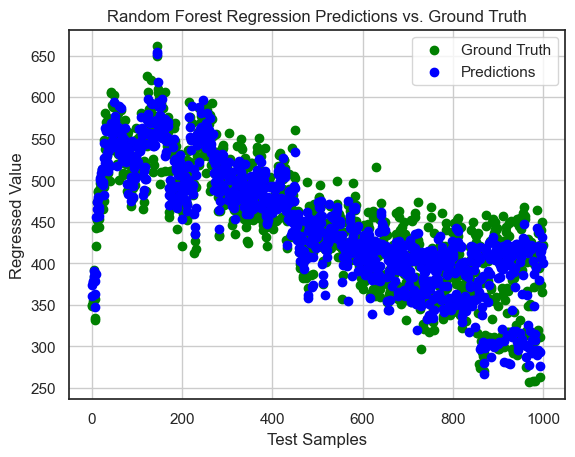

In [125]:
# scatter plot of the first_k data samples of the last fold in k-fold (arbitrarily chosen to see if model learns the patterns)
first_k = 1000
sample_pred = rf_model.predict(test_x)[:first_k]
sample_gt = test_y.iloc[:, 0].tolist()[:first_k]

# Create scatter plots for predictions and ground truth
plt.scatter(range(len(sample_gt)), sample_gt, color='green', label='Ground Truth')
plt.scatter(range(len(sample_pred)), sample_pred, color='blue', label='Predictions')

plt.gca().set_aspect('auto', adjustable='datalim')
plt.xlabel('Test Samples')
plt.ylabel('Regressed Value')
plt.title('Random Forest Regression Predictions vs. Ground Truth')
plt.legend(facecolor='white')
plt.grid(True)
plt.show()

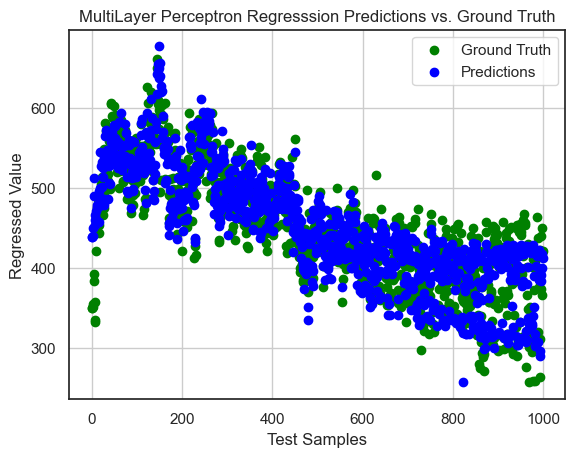

In [137]:
# scatter plot of the first_k data samples of the last fold in k-fold (arbitrarily chosen to see if model learns the patterns)
first_k = 1000
sample_pred = mlp_model.predict(test_x)[:first_k]
sample_gt = test_y.iloc[:, 0].tolist()[:first_k]

# Create scatter plots for predictions and ground truth
plt.scatter(range(len(sample_gt)), sample_gt, color='green', label='Ground Truth')
plt.scatter(range(len(sample_pred)), sample_pred, color='blue', label='Predictions')

plt.gca().set_aspect('auto', adjustable='datalim')
plt.xlabel('Test Samples')
plt.ylabel('Regressed Value')
plt.title('MultiLayer Perceptron Regresssion Predictions vs. Ground Truth')
plt.legend(facecolor='white')
plt.grid(True)
plt.show()

In [119]:

r2 = r2_score(test_y['Meter Reading (KWHr)'], rf_model_pred)
print(f"Test set R² (Random Forest Regression): {r2}")

r2 = r2_score(test_y['Meter Reading (KWHr)'], mlp_model_pred)
print(f"Test set R² (MultiLayer Perceptron Regresssion): {r2}")



Test set R² (Random Forest Regression): 0.84857755906831
Test set R² (MultiLayer Perceptron Regresssion): 0.7842342558536186


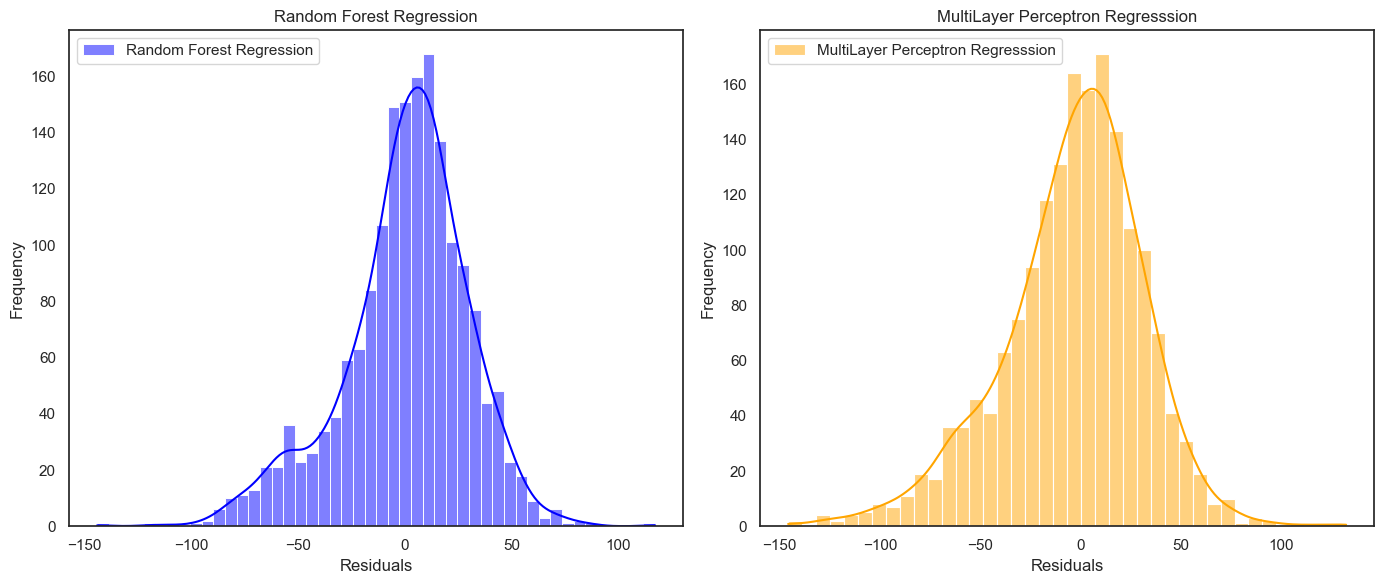

In [132]:
residuals1 = test_y['Meter Reading (KWHr)']- rf_model_pred
residuals2 = test_y['Meter Reading (KWHr)']- mlp_model_pred

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuals1, kde=True, color='blue', label='Random Forest Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Random Forest Regression')
plt.legend(facecolor='white')

plt.subplot(1, 2, 2)
sns.histplot(residuals2, kde=True, color='orange', label='MultiLayer Perceptron Regresssion')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('MultiLayer Perceptron Regresssion')
plt.legend(facecolor='white')

plt.tight_layout()
plt.show()

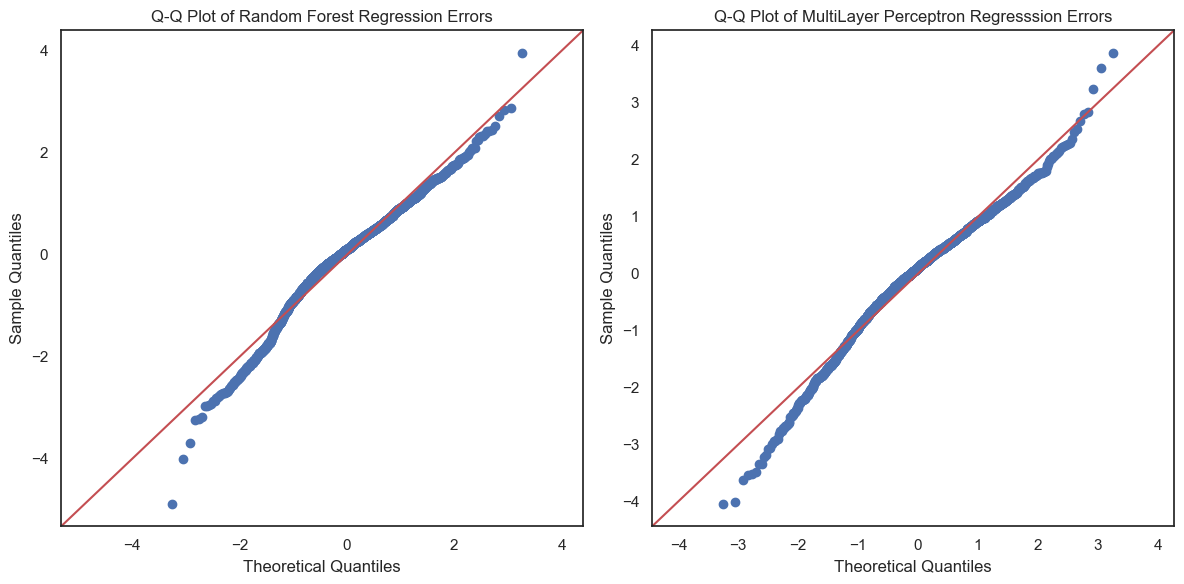

In [134]:
Q_Q1 = test_y['Meter Reading (KWHr)']- rf_model_pred
Q_Q2 = test_y['Meter Reading (KWHr)']- mlp_model_pred


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sm.qqplot(Q_Q1, line='45', fit=True, ax=plt.gca())
plt.title('Q-Q Plot of Random Forest Regression Errors')


plt.subplot(1, 2, 2)
sm.qqplot(Q_Q2, line='45', fit=True, ax=plt.gca())
plt.title('Q-Q Plot of MultiLayer Perceptron Regresssion Errors')

plt.tight_layout()
plt.show()

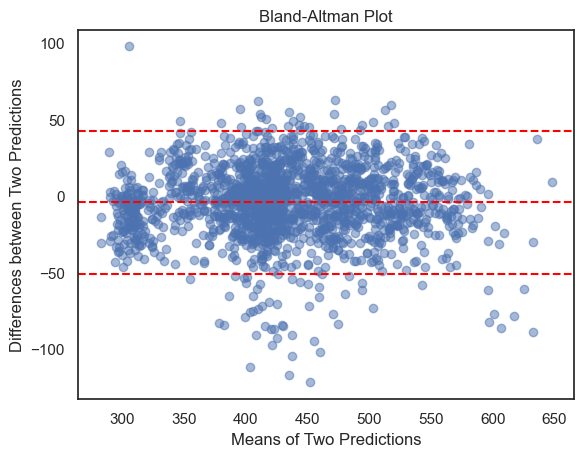

In [135]:
pred1=rf_model_pred
pred2=mlp_model_pred
means = (pred1 + pred2) / 2
differences = pred1 - pred2
mean_difference = np.mean(differences)
std_difference = np.std(differences)

plt.scatter(means, differences, alpha=0.5)
plt.axhline(mean_difference, color='red', linestyle='--')  
plt.axhline(mean_difference + 1.96*std_difference, color='red', linestyle='--')  
plt.axhline(mean_difference - 1.96*std_difference, color='red', linestyle='--')  
plt.title('Bland-Altman Plot')
plt.xlabel('Means of Two Predictions')
plt.ylabel('Differences between Two Predictions')
plt.show()

# Bland-Altman Plot
By observing the Bland-Altman plot, you can assess the consistency between the prediction results of two models. If most points closely cluster around the mean difference line and are evenly distributed within the limits of agreement, it suggests that the two models have good consistency. If the differences systematically increase or decrease as the mean values increase, it may indicate the presence of a proportional bias.